# Chapter : 7

>* Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that **this aggregated answer is better than an expert’s answer**. This is called the `wisdom of the crowd`.

>* Similarly, if you **aggregate the predictions of a group of predictors** (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. 

>* A group of predictors is called an `ensemble`; thus, this technique is called **`ensemble learning`**, an **ensemble learning algorithm** is called an **`ensemble method`**.

>* **As an example** of an ensemble method, you can train a group of decision tree classifiers, *each on a different random subset of the training set*. You can then obtain the predictions of all the individual trees, and **the class that gets the most votes** is the `ensemble’s prediction`.

>* Some popular ensemble methods are (`voting classifiers`, `bagging and pasting ensembles`, `random forests`, `boosting`, and `stacking ensembles`)

>* The following task illustrates how we used the `DecisionTreeClassifier` in making a `Random Forest`.
>>* We have 12_000 instances of whole data data (10_000 for train and 2000 for test).
>>* We split into 1000 split after shuffling upon each split.
>>* We train each split by this: we divide the whole 10_000 instance into 100 train and 9900 test. (Now we have 1000 trained Decision tree models)
>>* We use each one of the 1000 to make prediction on the whole test data we have (2000 instance).
>>* Now each instance of the 2000 has 1000 predicted value.
>>* We take the most vote (most repeated prediction of the 1000 for each instance of the 2000 instances).



In [4]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
x_train , y_train = make_moons(n_samples=10000, noise=0.4, random_state=42)
x_train.shape , y_train.shape

((10000, 2), (10000,))

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.2, random_state =42 )

In [6]:
import warnings
warnings.filterwarnings('ignore')

tree_clf = DecisionTreeClassifier(random_state=42)
param = {'max_leaf_nodes':[8,10,12,20,30,50,100],
         'max_depth':[5,8,9,100]}

clf = GridSearchCV(tree_clf, param)
clf.fit(x_train, y_train)
clf.best_params_

{'max_depth': 8, 'max_leaf_nodes': 20}

In [7]:
y_pred = clf.predict(x_test)
y_pred


array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
clf.score(x_test,y_test)

0.87

In [9]:
from sklearn.model_selection import ShuffleSplit

In [10]:
x_train.shape

(8000, 2)

In [11]:
sh_split = ShuffleSplit(n_splits= 1000, train_size=100,random_state=42 )
# the same instance may be selected more than once in many shuffles.

In [12]:
mini_sets = []

for mini_train_index, mini_test_index in sh_split.split(x_train):
    x_mini_train = x_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((x_mini_train, y_mini_train))

In [13]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score

forest = [clone(clf.best_estimator_) for _ in range(1000)]

accuracy_scores = []

for tree, (x_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(x_mini_train, y_mini_train)
    
    y_pred = tree.predict(x_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.801048

In [14]:
y_pred = np.empty([1000, len(x_test)], dtype=np.int8)

for tree_index , tree in enumerate(forest):
    y_pred[tree_index] = tree.predict(x_test)

In [15]:
type(y_pred)

numpy.ndarray

In [16]:
from scipy import stats

m = stats.mode(y_pred,axis = 0)
type(m)

scipy.stats.stats.ModeResult

In [17]:
accuracy_score(y_test, m[0].reshape(-1))

0.872

_________________________________

>* Coditions for using ensemble learning correctly:
>>* In fact, even if each classifier is a **weak learner** (meaning it does only slightly better than random guessing on worst case), the ensemble can still be a **strong learner** (achieving high accuracy), provided there are a sufficient number of weak learners in the ensemble and they are sufficiently diverse.

> A problem with ensemble learning (just for reading):
>* Suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy

>* Note: `Ensemble methods` work best when the predictors are **as independent from one another as possible**.
>>* One way to get diverse classifiers is to `train them using very different algorithms`. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.
>>* Another approach is to `use the same training algorithm for every predictor but train them on different random subsets` of the training set. When the samples taken with replacement, this is called **`bagging`** (short for bootstrap aggregating). When the samples taken with replacement, this is called **`pasting`**.


### Voting Classifiers:

>* `RandomForest` implements ensemble learning when it has many decision trees.
>* `VotingClassifier` implements ensemble learning when it has more than one classifier classifiers (SVC, RandomForestClassifier, etc). 


>* Voting classifiers has two types:
>>* `Hard voting`: if you have for example three classifiers and each of them predicted a class, then the voting classifier prediction is the class with the maximum number of occurence.
>>* `Soft voting`: if you have the same three classifiers you can get the `predict_proba()` of each class for a given instance, then the voting classifier prediction is the class with the highest probability averaged over the all individuals classifiers.


In [18]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

# the above implements `Hard voting` prediction.


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

>* When you fit a `VotingClassifier`, it **clones every estimator** and **fits the clones** not the original one.
>* The **original estimators** are available via the `estimators` attribute, while the **fitted clones** are available via the `estimators_` attribute.
>* If you prefer a dict rather than a list, you can use `named_estimators` or `named_estimators_` instead.

In [19]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test,y_test))

print("hard voting_classifier_ score =", voting_clf.score(X_test,y_test))

lr = 0.864
rf = 0.896
svc = 0.896
hard voting_classifier_ score = 0.912


In [20]:
voting_clf.predict(X_test[:1])

[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

>* Note: `SVC` doesn't have `predict_proba()` by default so if you managed to use `soft_voting`, you should set its hyper-parameter `probability` to **True**. (this will make the `SVC` class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method).

>* Note: `Soft voting` often gets higher accuracy than `hard voting` because it gives more weight to highly confident votes.

In [21]:
voting_clf.voting ='soft'
voting_clf.named_estimators['svc'].probability = True # named_estimators is the original one not the cloned one ...
voting_clf.fit(X_train, y_train) # the fitting is done on the cloned one 
voting_clf.score(X_test, y_test)

# the above generates soft voting prediciton.

0.92

_____________

>* both bagging and pasting allow training instances to be sampled several times across multiple predictors.
> 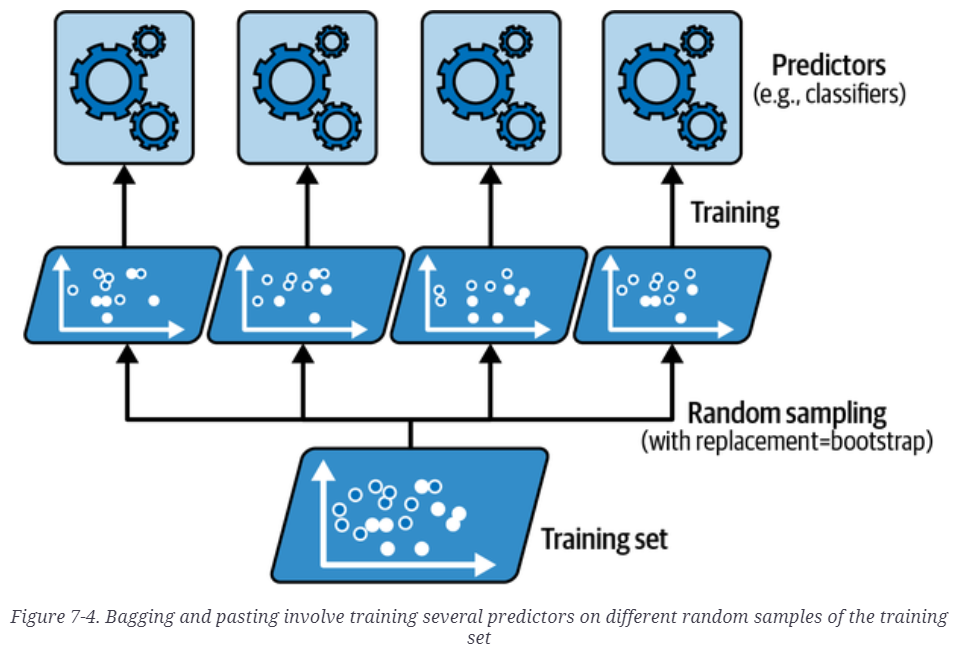

>* Difference between `voting classifier` and `bagging or pasting` is that `voting classifier` uses different algorithms but `bagging or pasting` trains the same algorithm on different samples. (this to achieves the independences.)

>* Once all predictors are trained, the ensemble can make a prediction for a new instance `by simply aggregating the predictions of all predictors`.

>* The aggregation function is typically the **`statistical mode for classification`** (i.e., the most frequent prediction, just like with a hard voting classifier), or **`the average for regression`**.

>* Predictors in bagging or pasting can all be `trained in parallel`, via different CPU cores ... This makes them scales well as you scale your data. 

>* You can determine the number of cores used in training by using `n_jobs` hyperparameter. or set it to `-1` if you want to use all available cores.

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf= BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                           max_samples= 100, n_jobs= -1, random_state=42)
# here we used 500 classifier each classifier is trained on random 100 sample
# here also we did bagging by default, to do pasting, we should:
# set `bootstrap = False`

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

>* A `BaggingClassifier` automatically **performs soft voting** instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with decision tree classifiers.
>* The `VotingClassifier` uses hard voting by default.
>* We know `soft voting` is often better than `hard voting`. Also, we know **`bagging`** performs better than **`pasting`**.

> 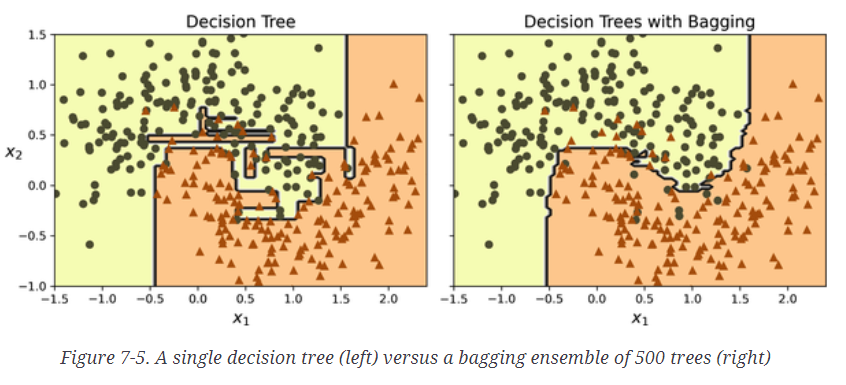

Note this difference between `bagged_trees` and `random_forests`:

>* There is a disctinction between bagging and bagged trees.
>* Bagging (bootstrap + aggregating) is using an ensemble of models where:
>>* each model uses a bootstrapped data set (bootstrap part of bagging)
>>* models' predictions are aggregated (aggregation part of bagging)
>>* This means that in bagging, you can use any model of your choice, not only trees.
>* Further, bagged trees are bagged ensembles where each model is a tree.
>* So, in a sense, each bagged tree is a bagged ensemble, but not each bagged ensemble is a bagged tree.
>* Given this clarification:

>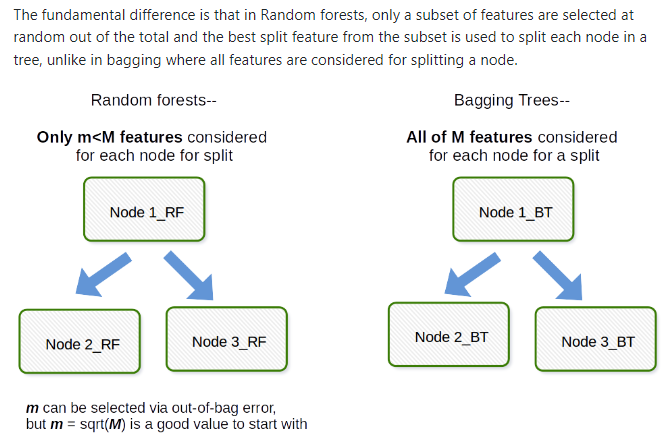

>* The author has discussed an important note about OOB(out-of-bag) instances and how can we use them instead of validation dataset: 
>* 📌 [**See This Post**](https://www.linkedin.com/feed/update/urn:li:activity:7084903051383246848/) 📌
> 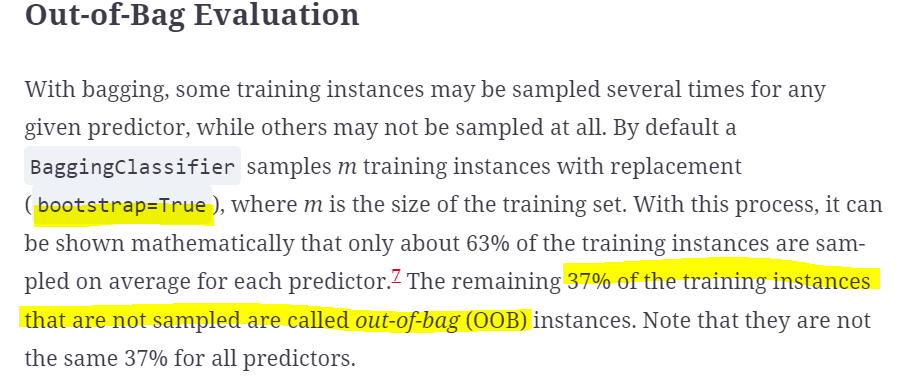
>* This means after training, we will have 0.37 of the instances are out-of-bag ... we can use them for evaluation ... "but take care to fix the random state each time" in order not to tune the model on different dataset.


In [23]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

# this is equivalent to the validation_score 

0.896

In [24]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

# this is the test score

0.92

>* From the above, we notice that:
`accuracy_score` is the same as `.score()` method in their mathematical formulas.

The OOB decision function for each training instance is also available through the `oob_decision_function_` attribute. Since the base estimator has a `predict_proba()` method, the decision function returns the class probabilities for each training instance. 

In [25]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539],
       [0.75586854, 0.24413146],
       [0.0049505 , 0.9950495 ],
       [0.75520833, 0.24479167],
       [0.82122905, 0.17877095],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.35087719, 0.64912281],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6635514 , 0.3364486 ],
       [0.

#### `Random_patches` method vs `random_subspaces` method:
>* `BaggingClassifier()` can be used in sampling the instances (by setting `bootstrap=True`, and determine the sample size via `max_samples`).
>* Also, this class provide sampling the features "**It is important if the featuers are large like images**" (via setting `bootstrap_features=True`, and the feature sample size via `max_features`)

>`max_features` : int or float, default=1.0
>>The number of features to draw from X to train each base estimator (
    without replacement by default, see `bootstrap_features` for more
    details).
>>- If int, then draw `max_features` features.
>>- If float, then draw `max_features * X.shape[1]` features.

>* **`Random_Patches`**: is when you sample both training instances & features.
>* **`Random_Subspaces`**: is when you sample sample features only and use the whole training instances in the training without any bootstrap sampling.

>* `RandomForestClassifier()` is the the same as `BaggingClassifier()` when bassing `bootstrap = True` to enable bagging, and typically `max_samples` is 1 (the size of training examples). 
>* Moreover, there is a difference in that, the random_forest samples the features by default "you don't need to sample the features" ... by default, the `RandomForestClassifier()` imulate **max_features = √n**

In [26]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

>* With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to **control how trees are grown**), plus all the hyperparameters of a `BaggingClassifier` to control the **ensemble itself**.

>* The random forest algorithm introduces extra randomness when growing trees; **instead of searching for the very best feature when splitting a node, it searches for the best feature among a *random* subset of features**. By default, it samples √n features (where n is the total number of features). 
>* The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.
>* The following two pieces of code are similar:

In [27]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)

bgg_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),n_estimators=500,
                            n_jobs = -1, random_state=42)

#By default, both BaggingClassifier() & RandomForestClassifier() has bootstrap=True (means by default they do bootstrap sampling)


##### extra-trees ensemble:
>* As we've discussed in RandomForests, in each sub-DecisionTree, we choose the splitting features at each node from a random subset of features. The size of this set is **√n**.

>* We can make the RandomForestClassifier or RandomForestRegressor more random by **randomizing the splitting threshold** at each feature for each sub `DecisionTreeClassifier()` by passing a hyperparameter `splitter = random` for each sub tree.
>* In this case, the random forest is called **`"extra randomized-trees ensemble"`** or **`extra-trees ensemble`** for short.

>* By the way, there is a class for that called: `ExtraTreesClassifier()` & `ExtraTreesRegressor()` with the same API as for RandomForestClassifier and RandomForestClassifier but default **`bootstrap=False`** 

>>* In DecisionTree, the **threshold** is a certain value of the faetures used in splitting.(that is if the feature value for the instance is greater than this threshold or lower than it or whatever we say, we then can do splitting).

>* This randomization shifts add bias to our model to make it reduce the variance.
>* This `extra-trees ensemble` method is **faster in training than** `random-forest` because choosing the best splitting threshold is a time-consuming task. <font color ='red'>**BUT** </font> **You should try both and judge what gives you higher score**.

##### Feature Importance:
>* In Random Forests, it is easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at **how much the tree nodes that use that feature reduce impurity on average**, across all trees in the forest. (if one feature is important one, it will reduce the impurity as much as it could throught out the node it used at.)
>* More precisely, it is a weighted average, where **each node’s weight is equal to the number of training samples that are associated with it**.
>* Scikit-Learn **computes this score automatically for each feature** after training, **then it scales the results** so that the sum of all importances is equal to 1.
>* This feature_importance is helpful if you need to perform feature selection.

In [28]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)


for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
     print(round(score, 2), name)


0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


_____________________________

##### Boosting:
>* Originally called hypothesis boosting) refers to any ensemble method that can combine several weak learners into a strong learner.
>* Idea is to train predictors **sequentially**, each trying to correct its predecessor.
>* Most two important boosting techniques are: "`AdaBoost (Adaptive Boosting)` & `Gradient Boosting`".

###### >*AdaBoost

>* One way for a new predictor to correct its predecessor is to **pay a bit more attention to the training instances that the predecessor underfit**. This results in new predictors focusing more and more on the hard cases. This is the technique used by `AdaBoost`.

>* 1. For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a decision tree) **and uses it to make predictions on the training set**. 

>* 2. The algorithm **then increases the relative weight of misclassified training instances**. 

>* 3. Then **it trains a second classifier, using the updated weights**, and again makes predictions on the training set, updates the instance weights, and so on (see The Figure). 
>* 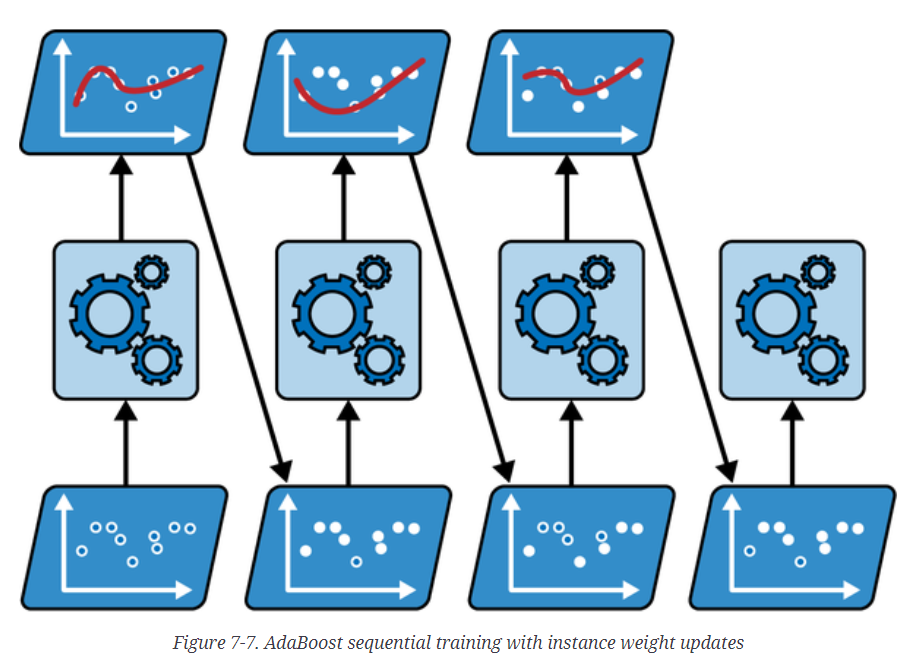

>* The following figure shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier "highly regularized means weak model with high bias" with an RBF kernel).⁠
>* The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. 
>* The plot on the right represents the same sequence of predictors, **except that the learning rate is halved** (i.e., the misclassified instance weights are boosted much less at every iteration). 
>* As you can see,<font color='red'> **this sequential learning technique has some similarities with gradient descent**</font>, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.
>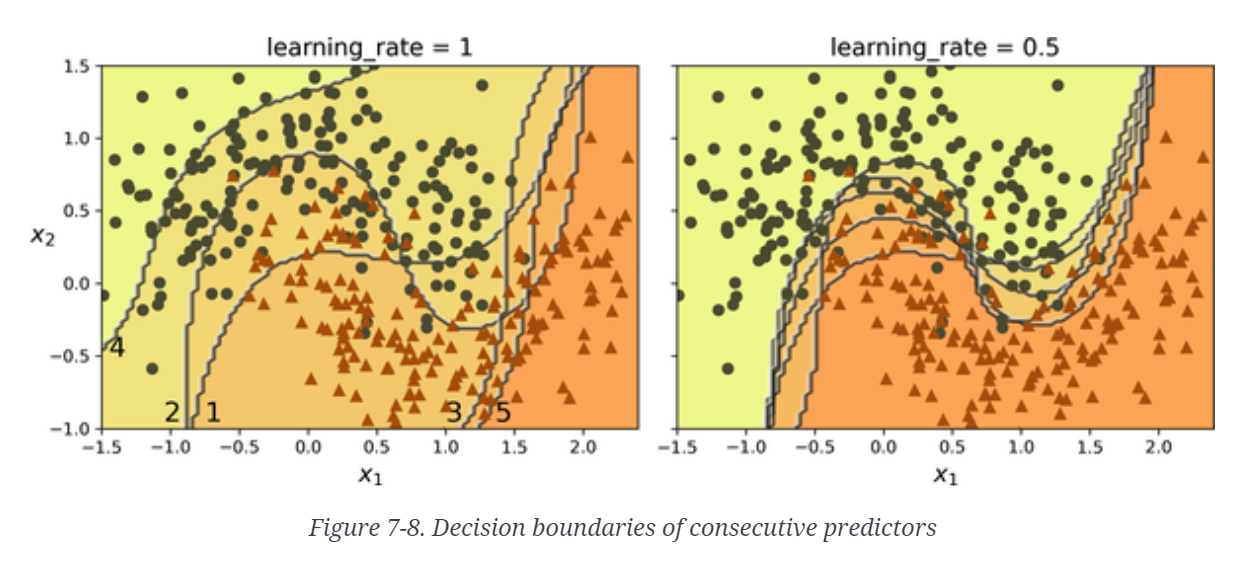

>* Now, we have 4 weighted model, **we use them all to make predictoin** either using voting or predict_proba "for classification" or aggregating by averaging for "regression". (مش متأكد)
>* Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, **except that predictors have different weights** depending on their overall accuracy on the weighted training set.

>* **One drawback** of boosting is that, `it works sequentially` unlike bagging and pasting parallel nature. THerefore, this sequntial nature makes it scales worse than bagging and pasting to larger data.

>* In general Adaptive Boosting (AdaBoost) try to update the weights for the incorrectly misclassified sample from the previous predictor and make the current predictor focus more on them.
>* For details [**In this video**](https://www.youtube.com/watch?v=LsK-xG1cLYA), we do the following:
>> 1. Intialize a weight for each instance `[w(i) = 1/m]` where m is the number of training instances.
>> 2. Calculate the total error `r(j)` for each j-predictor. Total error is simply the sum of all the weights of mis-classified samples for this j-predictor. Note **each ensemble predictor using AdaBoost is often a  `stumb` (one decision tree with max-depth of 1)**
>> 3. Then we calculate the weight of each predictor `α(j)` "amount of say for this j-predictor" via the relation. This could be used later in the total ensemble prediction.
>> |A|B|
>> |-|-|
>> |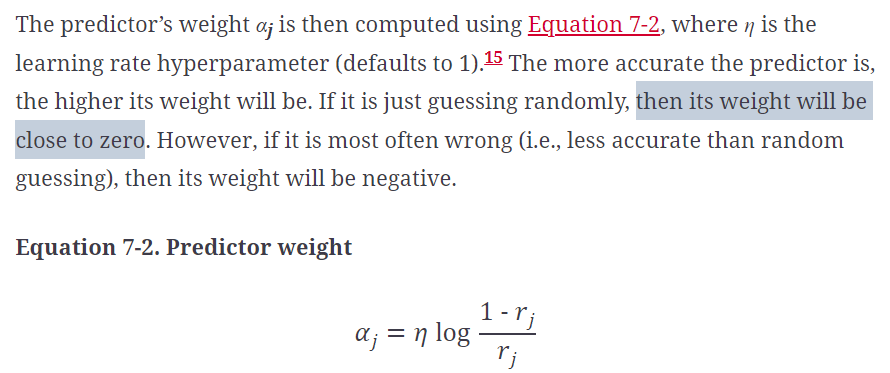|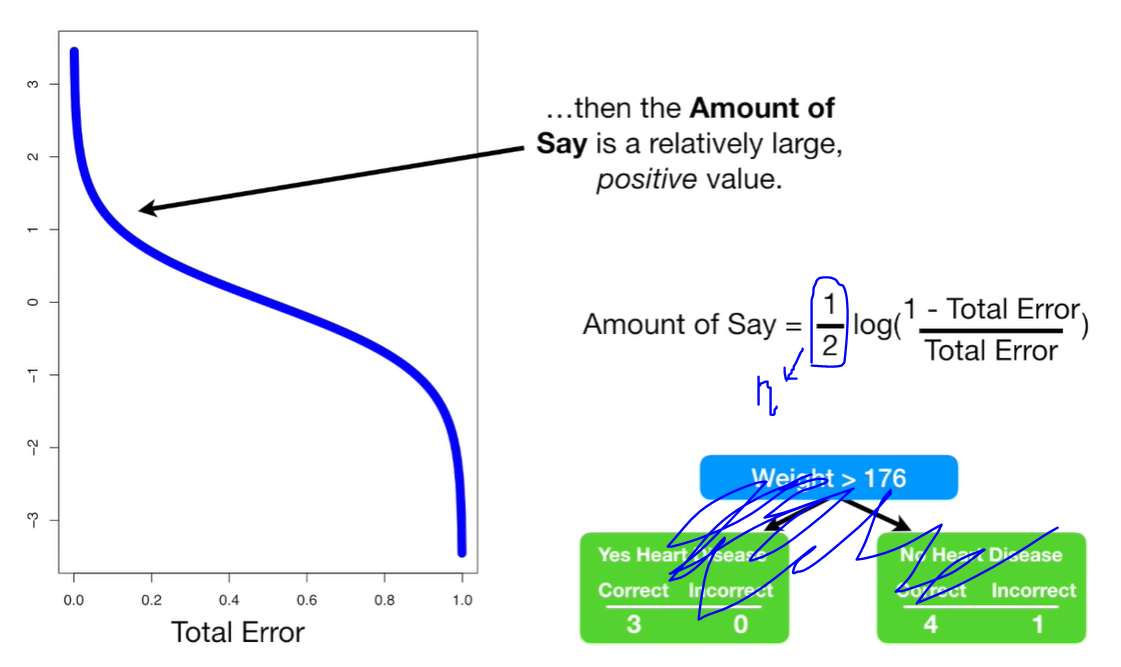|
>> 4. Not only we use `α(j)` for final prediction, but we use it also in updating the weights of the misclassified samples. We update those weights by increasing them than their intial 1/m value, by the following rule:
>> |A|B|
>> |-|-|
>> |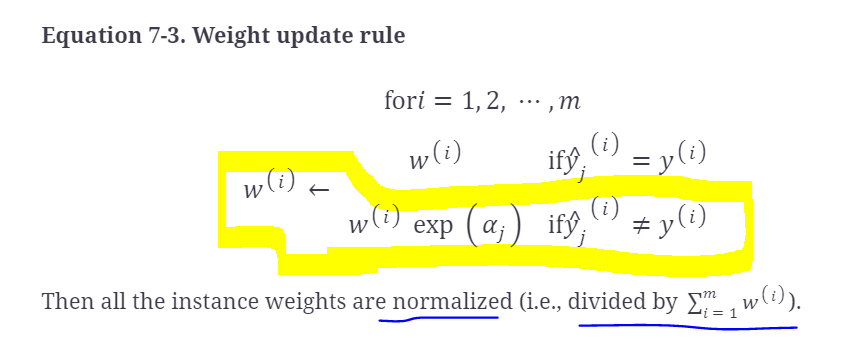|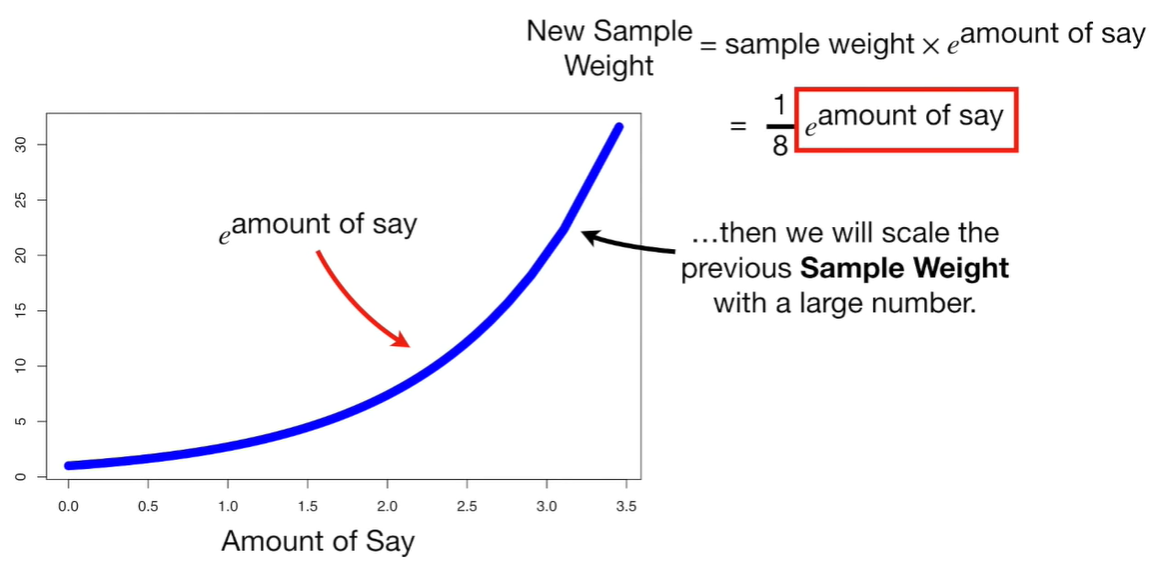|
>> 5. The weights are then normalized to add up to 1.
>> 6. To make predictions:
>> 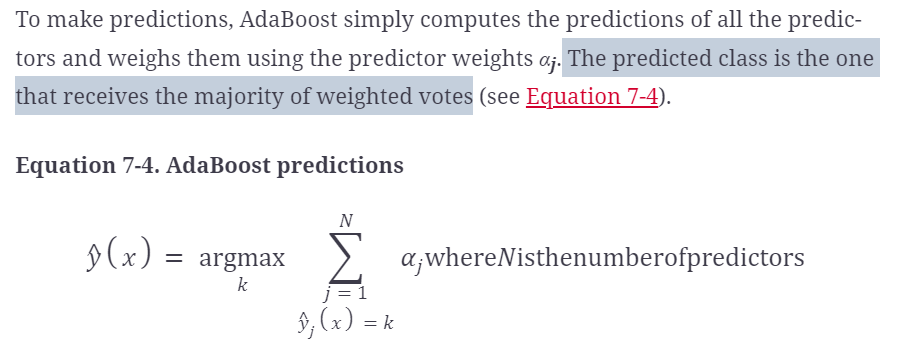
______________________________________________

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
                            DecisionTreeClassifier(max_depth=1), n_estimators=30,
                            learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

# If you deal with multi-class problem, There is a similar class that you can use `SAMME` or `SAMME.R`. 

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

>* **<font color='red' >Note**:</font> If your **AdaBoost ensemble is overfitting the training set**, you can try reducing the number of estimators or more strongly regularizing the base estimator. 

###### >*Gradient Boosting:
You can understand it from the following exapmles, it uses sequintial learning but on the residual errors of the previous predictor not the weights of the samples: 

In [57]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)
 
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [61]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [62]:
y3 = y2 - tree_reg1.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

>* Note how we change the `random_state` to make a different decision tree.

In [63]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


array([-5.55111512e-17, -9.03979359e-02,  3.99129745e-02])

>* The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.
>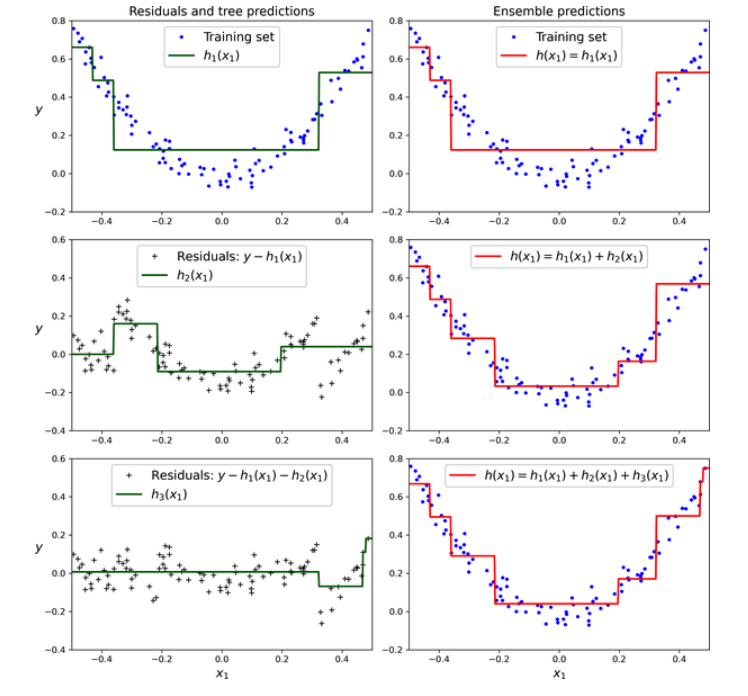

>* Note: Using DecisionTree as the base predictor for gradient boosting is sth called gradient boosted regression tree (GBRT). This is a class to do so `GradientBoostingRegressor`.
>* Both `GradientBoostingRegressor` and `RandomForestRegressor` use Decision Trees as their base estimators but they differs in how they benefit from ensemble. The former applies the concept of `Boosting` and latter applies the concept of `Bagging`. 

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
# it implicitly use the decisino trees as their base estimator.


gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=42)

gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

>* learning rate hyperparameter scales the contribution of each predictor ('decision tree' in GradientBoostingRegressor) ... means if learning_rate = 1 ... each model contributes with all of its predictions (مش متأكد):
>* `learning_rate` : float, default=0.1
    Learning rate shrinks the contribution of each tree by `learning_rate`.
>* <font color ='red'> **There is a trade-off between `learning_rate` and `n_estimators`**.</font>
> 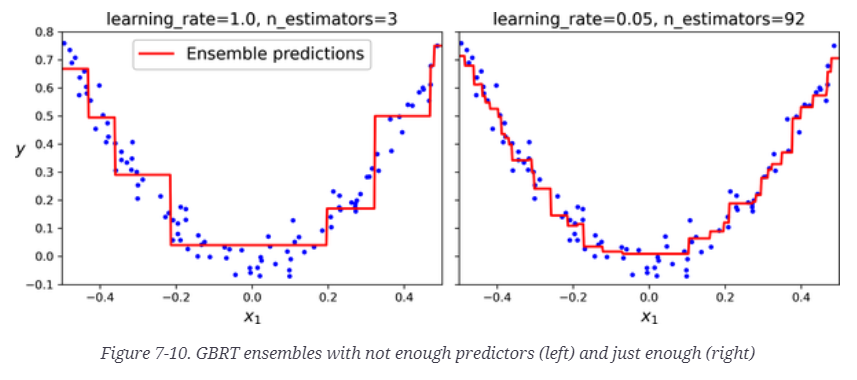

>* To get the best number of estimators, we can use the `GridSearchCV` or `RandomizedSearchCV` but there is a built in hyperparameter `n_iter_no_change`.
>* If you set the `n_estimators =92` and `n_iter_no_change = 10`, the sequential nature of the boosting model tries to stop adding more predictors if it sees the last 10 trees didn’t help.]
>* This technique is similar to early stopping.

In [65]:
gbrt_best = GradientBoostingRegressor(
        max_depth=2, learning_rate=0.05, n_estimators=500,
        n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [66]:
gbrt.n_estimators_

3

>* If you set `n_iter_no_change` too low, training may stop too early and the model will underfit. 
>* But if you set it too high, it will overfit instead. 
>* We also set a fairly small learning rate and a high number of estimators,
> 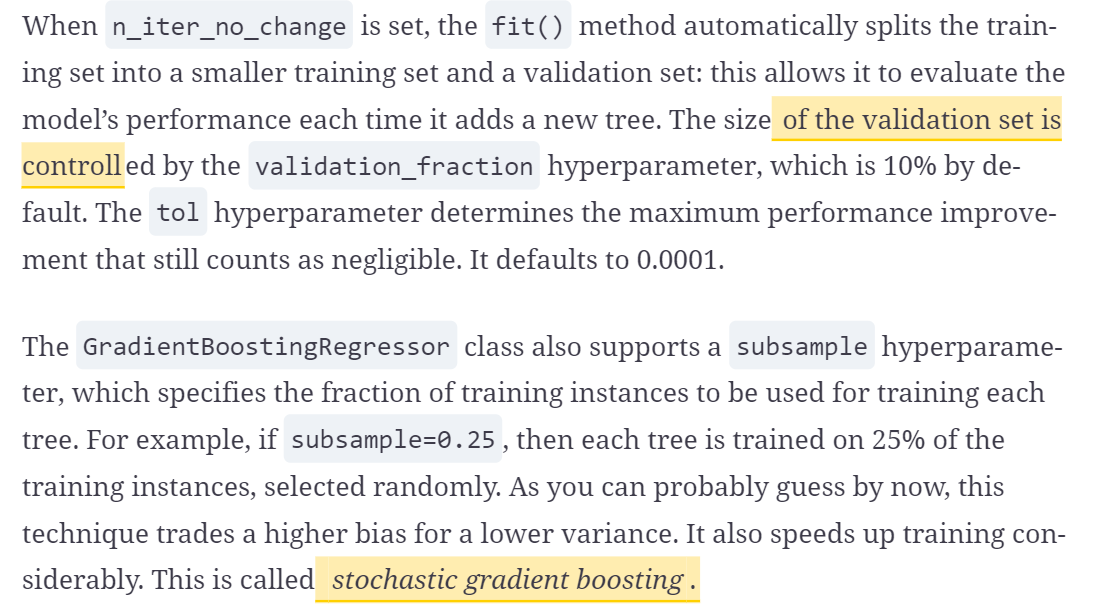

###### >*HistogramBasedGradientBoosting:
>* Another edition on GradientBoostingRegression "Ensemble learning method using DecisionTree as base estimator" is HistogramBasedGradientBoosting.
>* It is helpful with large-data as it aims to bins the number of features "accmulate multiple features in one single bin" thus reduce the number of threshold in splitting the nodes, thus reduce the computational time. 
>* The calss that supports this is `HistGradientBoostingRegressor()` & `HistGradientBoostingClassifier()`.
> 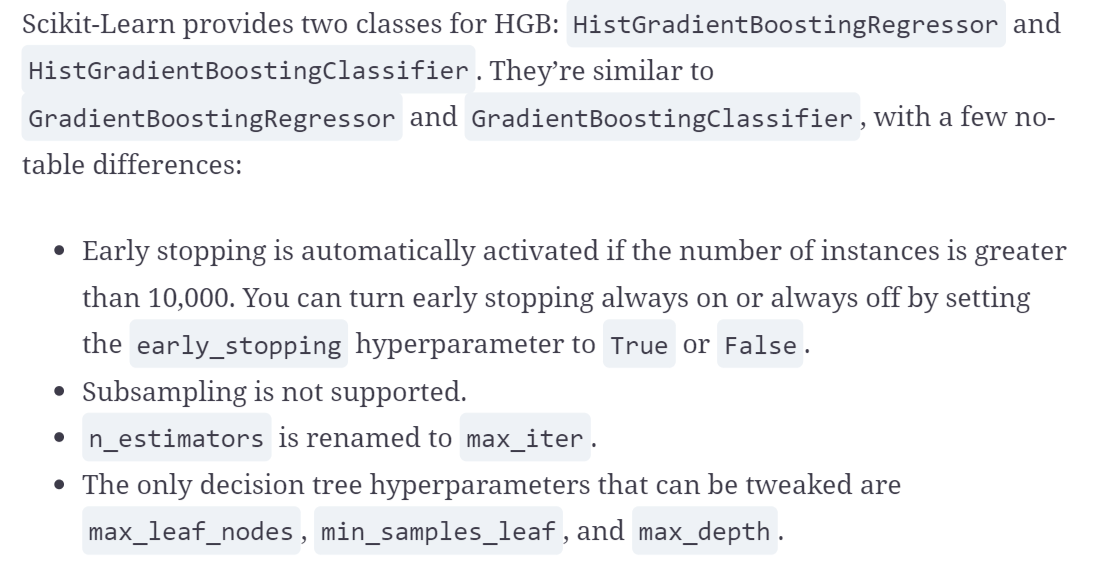

>* These two classes handle `missing values` and `category data` by default, you don't need to encode the data or impute the missing values.

In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from category_encoders import OrdinalEncoder


hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(),['ocean_proximity']),
                            remainder='passthrough'),
    HistGradientBoostingRegressor(categorical_features=[0],random_state=42)
    )

# Note that categorical_features must be set to the categorical column indices (or a Boolean array)
hgb_reg.fit(housing, housing_labels)

ImportError: cannot import name 'HistGradientBoostingRegressor' from 'sklearn.ensemble' (C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\__init__.py)

Note:
>* 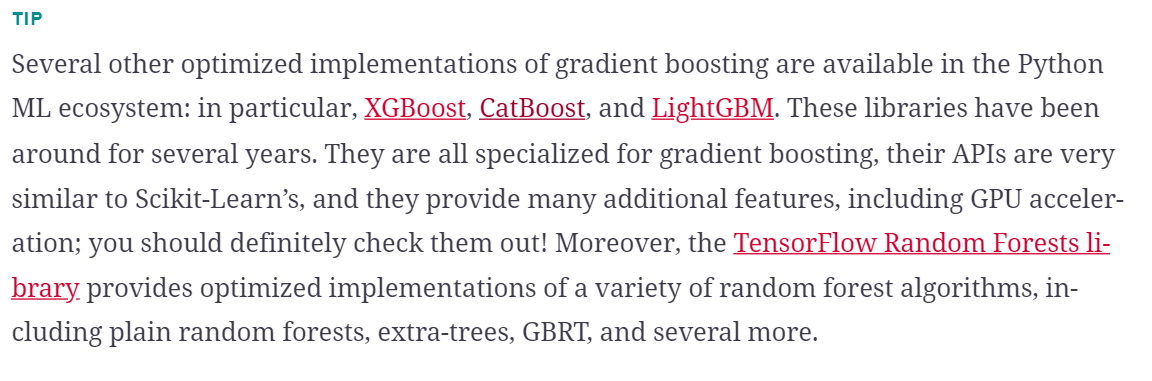

###### >*stacking:
>* Instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we **train a model to perform this aggregation**?
>* 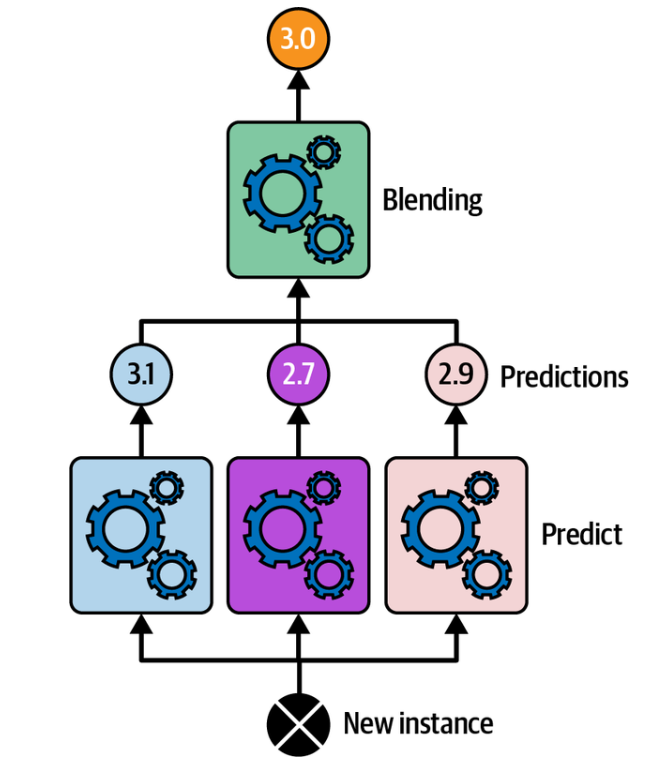

>* In stacking: after we used our ensemble learning model to come up with n-estimators predictions, we will use a model that takes those n-predictions as feature-values and predict the final output (this is instead of aggregating or voting).

>* To train this blending model, we train it after we train our ensemble block.
>>* We train the ensemble block using cross-val method in order to evaluate its performance before feeding the results to the blending layer.
>>* After we evaluate the ensemble block, we use the train-data as whole to train the blending layer ... by feeding them to the ensemble block as if we were to predict them... and in advance we use the label column as our label while training the blending layer.[**Importatnt Video**](https://www.youtube.com/watch?v=lcXKFS65BI0)
>* 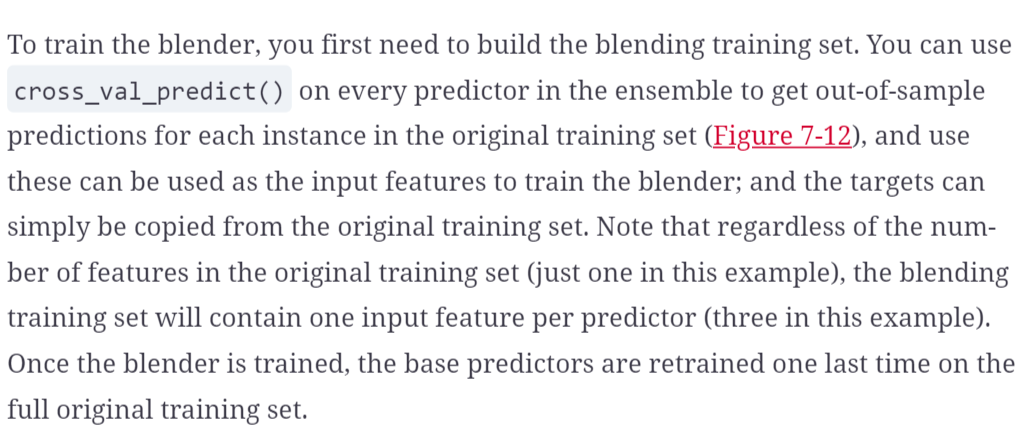
>* 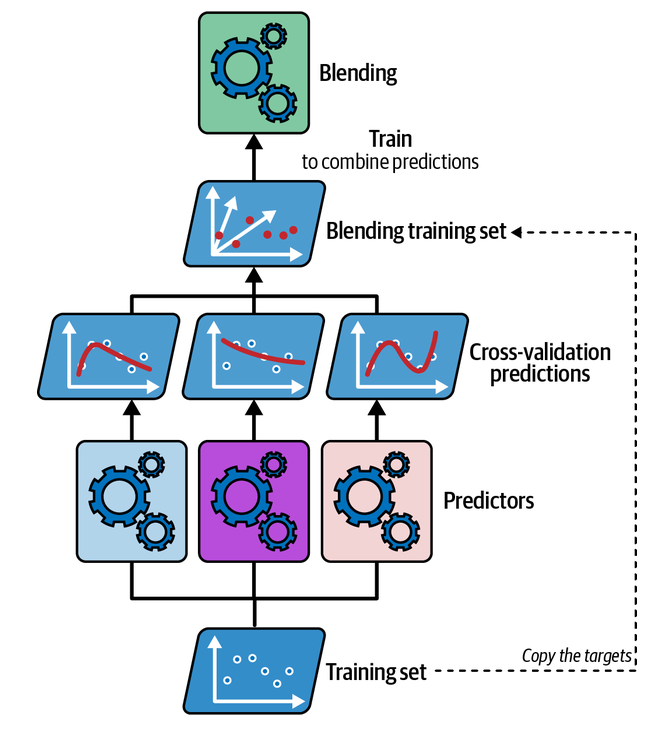

> Scikit-Learn provides two classes for stacking ensembles: `StackingClassifier` and `StackingRegressor`. For example, we can replace the `VotingClassifier`.

In [75]:
from sklearn.ensemble import StackingClassifier # for regression, StackingRegressor

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

>* Note the cv is used to create **`out-of-sample`** prediciton to get the whole number of instances.

In conclusion, ensemble methods are versatile, powerful, and fairly simple to use. `Random forests`, `AdaBoost`, and `GBRT` are among the first models you should test for most machine learning tasks, and they particularly shine with heterogeneous tabular data.
____________________